<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/Demo_optimize_broadband_rcwa_metalens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


This may take a minute or two so be patient! We are continously working to optimize repository size and structure. 

In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

%cd /content/DFlat
!python setup.py develop

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'DFlat'...
remote: Enumerating objects: 2953, done.
remote: Counting objects: 100% (974/974), done.
remote: Compressing objects: 100% (654/654), done.
remote: Total 2953 (delta 400), reused 824 (delta 305), pack-reused 1979
Receiving objects: 100% (2953/2953), 757.83 MiB | 23.39 MiB/s, done.
Resolving deltas: 100% (979/979), done.
Updating files: 100% (191/191), done.
Filtering content: 100% (23/23), 77.29 MiB | 47.79 MiB/s, done.
/content/DFlat
running develop
running egg_info
creating DFlat.egg-info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
writing manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest file 'DFlat.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Cr

In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 KB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.4 MB/s eta 0:00:00
  Created wheel for gdspy: filename=gdspy-1.6.12-cp38-cp38-linux_x86_64.whl size=597220 sha256=8d83a3c1f92ef6520bb060f39c3fa7d2e44d3f4dca8ce6c4040dd93c79e256b9
  Stored in directory: /root/.cache/pip/wheels/03/ed/d5/f89483da9ebf5b67e58ba967e19132ae7703a6409727790445
Successfully built gdspy
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12

# Create a general optimization pipeline using the psf layer and the rcwa optical model 

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import dflat.data_structure as df_struct
import dflat.optimization_helpers as df_optimizer
import dflat.physical_optical_layer as df_physical
import dflat.fourier_layer as df_fourier
import dflat.tools as df_tools
import dflat.plot_utilities as plt_util

from dflat.physical_optical_layer.core.ms_parameterization import generate_cell_perm

We first build an optimization class inheriting from the df_optimizer.Pipeline_Object (although you can choose to not use this).

By inheriting this class, all the details of saving and loading custom model checkpoints are taken care of. Moreover, this class allows us to use convenient, pre-written functions for training loops, enabling faster prototyping.  

Most of the lines below are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process when using the training helpers in the df_optimizer module! Defining this function overides the parent empy function and is entirely optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()

In [ ]:
# Print the list of pre-coded cell parameterizations
df_physical.list_cell_parameterizations()

['rectangular_resonators', 'coupled_rectangular_resonators', 'cylindrical_nanoposts']


Because we want interesting wavelength-dependent behavior, let us consider using the coupled_rectangular_resonators

In [ ]:
class pipeline_metalens_rcwa(df_optimizer.Pipeline_Object):
    def __init__(self, rcwa_parameters, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_metalens_rcwa, self).__init__(savepath, saveAtEpochs)

        self.rcwa_parameters = rcwa_parameters
        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        self.cell_parameterization = "coupled_rectangular_resonators"
        self.rcwa_latent_layer = df_physical.RCWA_Latent_Layer(self.rcwa_parameters, self.cell_parameterization)
        self.psf_layer = df_fourier.PSF_Layer(propagation_parameters)

        # Make uniform state latent tensor as initial variable for metasurface with helper function
        input_shape = self.rcwa_latent_layer.shape_vect_size
        init_latent = tf.random.uniform(shape=input_shape) - 0.5
        self.latent_tensor_variable = tf.Variable(init_latent, trainable=True, dtype=tf.float32)

    def __call__(self):
        out = self.rcwa_latent_layer(self.latent_tensor_variable)
        psf_intensity, _ = self.psf_layer(out, self.point_source_locs, batch_loop=False)

        # sum over the two polarization basis (x and y linear)
        psf_intensity = tf.reduce_sum(psf_intensity, axis=1)

        # Save the last lens and psf for plotting later
        self.last_lens = out
        self.last_psf = psf_intensity

        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto):
        # This overrides the baseclass visualization call function, called during checkpoints
        savefigpath = self.savepath + "/trainingOutput/"

        # Get parameters for plotting
        # Helper call that returns simple definition of cartesian axis on lens and output space (um)
        xl, yl = plt_util.get_lens_pixel_coordinates(self.propagation_parameters)
        xd, yd = plt_util.get_detector_pixel_coordinates(self.propagation_parameters)
        xl, yl = xl * 1e6, yl * 1e6
        xd, yd = xd * 1e6, yd * 1e6

        Lx = self.rcwa_parameters["Lx"]
        Ly = self.rcwa_parameters["Ly"]
        sim_wavelengths = self.propagation_parameters["wavelength_set_m"]
        num_wl = len(sim_wavelengths)

        ### Display the learned phase and transmission profile on first row
        # and wavelength dependent PSFs on the second
        trans = self.last_lens[0]
        phase = self.last_lens[1]

        fig = plt.figure(figsize=(25, 10))
        ax = plt_util.addAxis(fig, 2, num_wl)
        for i in range(num_wl):
            ax[i].plot(xl, phase[i, 0, 0, :], "k-")
            ax[i].plot(xl, phase[i, 1, 0, :], "b-")
            # ax[i].plot(xl, trans[i, 0, 0, :], "k*")
            # ax[i].plot(xl, trans[i, 1, 0, :], "b*")
            plt_util.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Lens radius (um)",
                ylabel="Phase (x and y polarized)" if i == 0 else "",
                title=f"wavelength {sim_wavelengths[i]*1e9:3.0f} nm",
                fontsize_text=12,
                fontsize_title=12,
                fontsize_ticks=12,
            )

            ax[i + num_wl].imshow(self.last_psf[i, 0, :, :], extent=(min(xd), max(xd), min(yd), max(yd)))
            plt_util.formatPlots(
                fig,
                ax[i + num_wl],
                None,
                xlabel="det x (um)",
                ylabel="det y (um)",
                title=f"Pol. avg PSF {sim_wavelengths[i]*1e9:3.0f} nm",
                setAspect="equal",
                fontsize_text=12,
                fontsize_title=12,
                fontsize_ticks=12,
            )
        #plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Lens.png")
        #plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Lens.pdf")
        #plt.close()

        ### Display some of the learned metacells
        # We want to assemble the cell's dielectric profile so we can plot it
        latent_tensor_state = self.latent_tensor_variable
        norm_shape_param = df_tools.latent_to_param(latent_tensor_state)
        ER, _ = generate_cell_perm(norm_shape_param, self.rcwa_parameters, self.cell_parameterization, feature_layer=0)
        disp_num = 5
        cell_idx = np.linspace(0, ER.shape[1] - 1, disp_num).astype(int)

        fig = plt.figure(figsize=(25, 5))
        ax = plt_util.addAxis(fig, 1, disp_num)
        for i, idx in enumerate(cell_idx):
            ax[i].imshow(np.abs(ER[0, idx, 0, 0, :, :]), extent=(0, np.max(Lx) * 1e9, 0, np.max(Ly) * 1e9))
            plt_util.formatPlots(
                fig,
                ax[i],
                None,
                xlabel="Cell x (nm)",
                ylabel="Cell y (nm)" if i == 0 else "",
                title="Lens r (um): " + f"{xl[idx]:3.0f}",
                fontsize_text=12,
                fontsize_title=12,
                fontsize_ticks=12,
            )
        #plt.savefig(savefigpath + "png_images/" + saveto + "epoch_Cells.png")
        #plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_Cells.pdf")
        #plt.close()
        plt.show()
        return

# Define Simulation Settings and run the optimization

We can now create a function that initializes our simulation setting and passes it to the newly initialized optimization pipeline. 

This pipeline can be trained easily since it is compatible with DFlats df_optimizer.run_pipeline_optimization() routine. This routine takes in a class that inherits df_optimizer.Pipeline_Object like done above.  

To train with this call, we define a loss function. Below, this is done in loss_fn. Note that currently when using this approach, the loss function can only take "pipeline_output" as an input! This means that the loss function should be defined explicitly in terms of the pipeline call function (or be defined inside the call function) so the output is the loss value itself).  

In many cases, you may want to write your own gradient descent training routine. You can learn how to do this by opening the code file and seeing how it is done in the run_pipeline_optimization call. 

Having a routine like this just helps with rapid design and testing


In [ ]:
def run_broadband_metalens(num_epochs=50, try_gpu=True):
  # Define save path
    savepath = "examples/output/multi_wavelength_rcwa_metalens_design/"
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    # Define Fourier parameters
    wavelength_list = [425e-9, 500e-9, 600e-9, 700e-9]
    point_source_locs = np.array([[0, 0, 1e6]])
    propagation_parameters = df_struct.prop_params(
        {
            "wavelength_set_m": wavelength_list,
            "ms_samplesM": {"x": 201, "y": 201},
            "ms_dx_m": {"x": 5 * 350e-9, "y": 5 * 350e-9},
            "radius_m": None,
            "sensor_distance_m": 1e-3,
            "initial_sensor_dx_m": {"x": 2.5e-6, "y": 2.5e-6},
            "sensor_pixel_size_m": {"x": 2.5e-6, "y": 2.5e-6},
            "sensor_pixel_number": {"x": 256, "y": 256},
            "radial_symmetry": True,
            "diffractionEngine": "fresnel_fourier",
            ### Optional keys
            "automatic_upsample": False,  # If true, it will try to automatically determine good upsample factor for calculations
            "manual_upsample_factor": 1,  # Otherwise you can manually dictate upsample factor
        },
        verbose=True,
    )
    gridshape = propagation_parameters["grid_shape"]

    # Define RCWA parameters
    fourier_modes = 5
    rcwa_parameters = df_struct.rcwa_params(
        {
            "wavelength_set_m": wavelength_list,
            "thetas": [0.0 for i in wavelength_list],
            "phis": [0.0 for i in wavelength_list],
            "pte": [1.0 for i in wavelength_list],
            "ptm": [1.0 for i in wavelength_list],
            "pixelsX": gridshape[2],
            "pixelsY": gridshape[1],
            "PQ": [fourier_modes, fourier_modes],
            "Lx": 400e-9,
            "Ly": 400e-9,
            "L": [650e-9],
            "Lay_mat": ["Vacuum"],
            "material_dielectric": "TiO2",
            "er1": "SiO2",
            "er2": "Vacuum",
            "Nx": 200,
            "Ny": 200,
        }
    )

    ## Call optimization pipeline
    saveAtEpochs=10
    pipeline = pipeline_metalens_rcwa(rcwa_parameters, propagation_parameters, point_source_locs, savepath, saveAtEpochs=saveAtEpochs)
    #pipeline.customLoad()  # Call to reload model checkpoint from savefile

    ## Define custom Loss function (Should always have pipeline_output as the function input if use helper)
    # You can write your own training function to for more control
    sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
    cidx_y = sensor_pixel_number["y"] // 2
    cidx_x = sensor_pixel_number["x"] // 2

    def loss_fn(pipeline_output):
        return -tf.reduce_sum(pipeline_output[:, 0, cidx_y, cidx_x])

    lr_sched = 1e-1#tf.keras.optimizers.schedules.ExponentialDecay(1e-1, 10, 0.95, staircase=False, name=None)
    optimizer = tf.keras.optimizers.Adam(lr_sched)
    df_optimizer.run_pipeline_optimization(pipeline, optimizer, num_epochs=num_epochs, loss_fn=loss_fn, allow_gpu=True)

    return


Training Log | (Step, time, loss):  0 10.762391328811646 -0.010040673506540159
Training Log | (Step, time, loss):  1 10.262685775756836 -0.04995338866546836
Training Log | (Step, time, loss):  2 5.55260705947876 -0.11400667885239968
Training Log | (Step, time, loss):  3 4.865973711013794 -0.19547540906512226
Training Log | (Step, time, loss):  4 4.803300380706787 -0.25532122426996645
Training Log | (Step, time, loss):  5 4.70159125328064 -0.30007161199013915
Training Log | (Step, time, loss):  6 4.7434539794921875 -0.33676178788829525
Training Log | (Step, time, loss):  7 4.798930644989014 -0.36532983435353344
Training Log | (Step, time, loss):  8 4.6959898471832275 -0.3842298362055357
Training Log | (Step, time, loss):  9 4.73606014251709 -0.4033481801831712
Log Training at step: 10


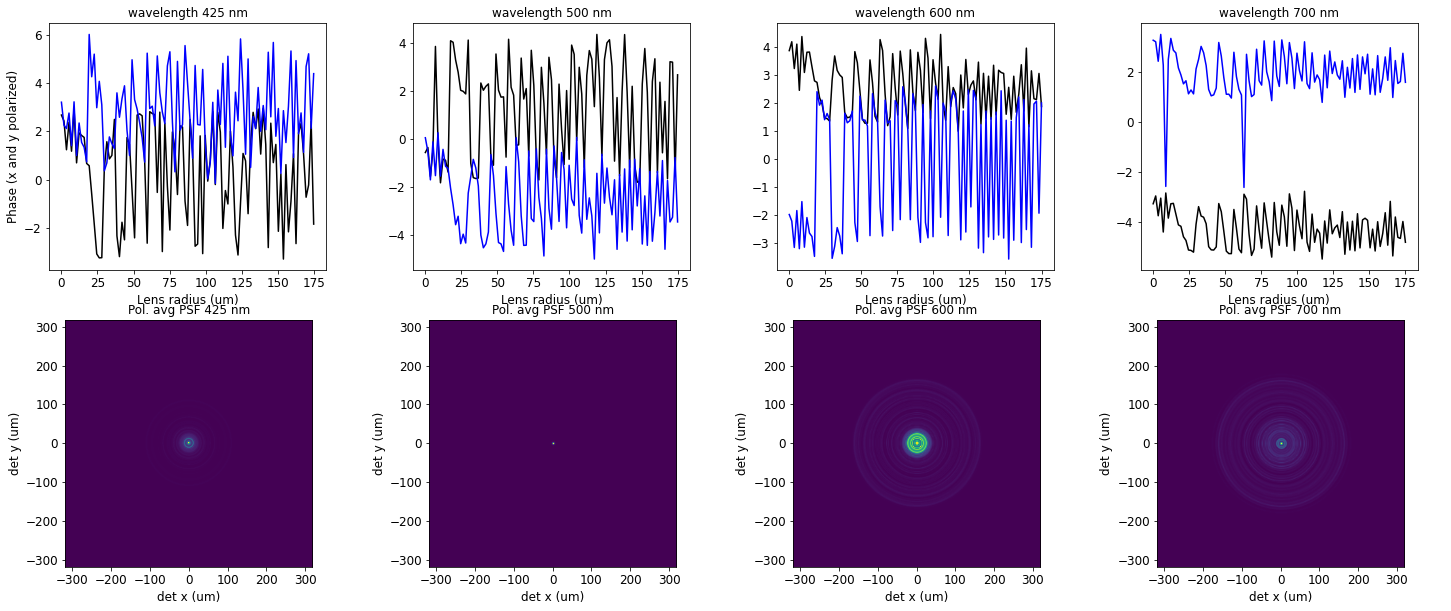

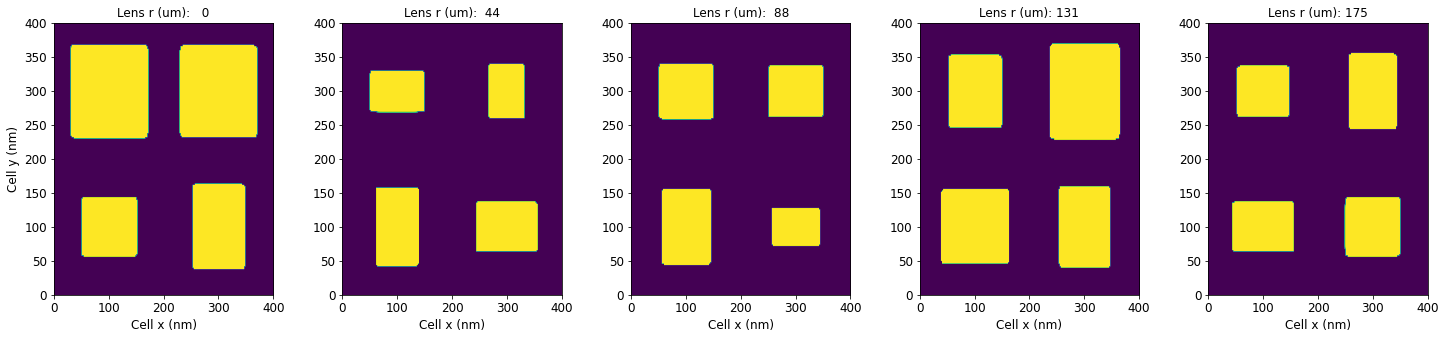

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:76: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  10 4.816279649734497 -0.42327012750581644
Training Log | (Step, time, loss):  11 5.135512828826904 -0.4393169746843527
Training Log | (Step, time, loss):  12 4.7174787521362305 -0.4564556041695639
Training Log | (Step, time, loss):  13 4.734037160873413 -0.47261606862801625
Training Log | (Step, time, loss):  14 5.553319931030273 -0.4871677738743694
Training Log | (Step, time, loss):  15 4.740180253982544 -0.5019563482671776
Training Log | (Step, time, loss):  16 4.767307996749878 -0.5124934004958062
Training Log | (Step, time, loss):  17 4.765324592590332 -0.5204680871368849
Training Log | (Step, time, loss):  18 5.662635564804077 -0.5274101437677875
Training Log | (Step, time, loss):  19 4.816505432128906 -0.5347057118962063
Log Training at step: 20


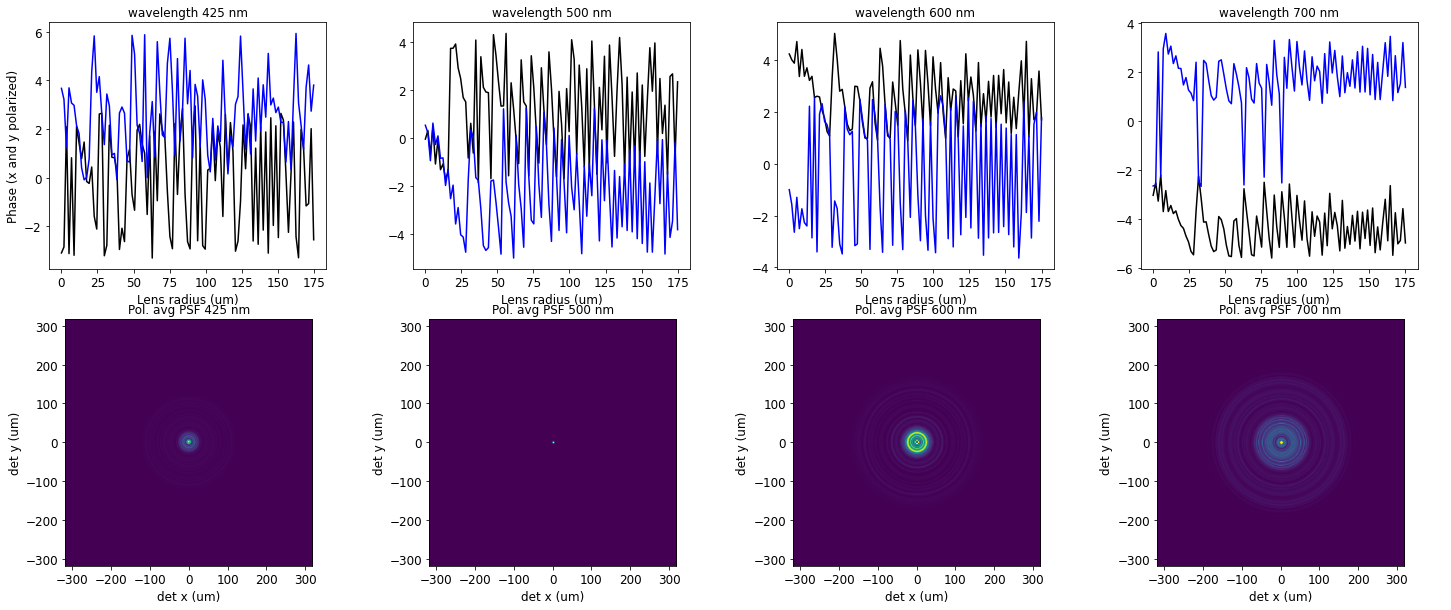

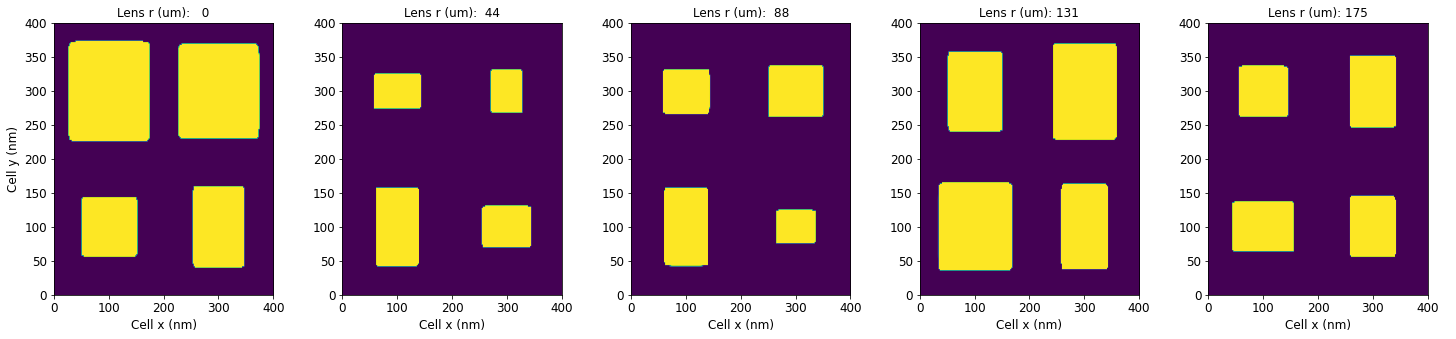

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:76: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  20 4.852269649505615 -0.539730141255981
Training Log | (Step, time, loss):  21 4.714369773864746 -0.5442309792794503
Training Log | (Step, time, loss):  22 4.787605285644531 -0.5504165733483553
Training Log | (Step, time, loss):  23 4.751038312911987 -0.5543193905980319
Training Log | (Step, time, loss):  24 4.787413120269775 -0.5596461002933317
Training Log | (Step, time, loss):  25 4.812571048736572 -0.561521992556964
Training Log | (Step, time, loss):  26 4.737578868865967 -0.5646608013884469
Training Log | (Step, time, loss):  27 4.734441518783569 -0.5679537751103888
Training Log | (Step, time, loss):  28 4.964383363723755 -0.5699802336488083
Training Log | (Step, time, loss):  29 4.725616455078125 -0.5711937769164787
Log Training at step: 30


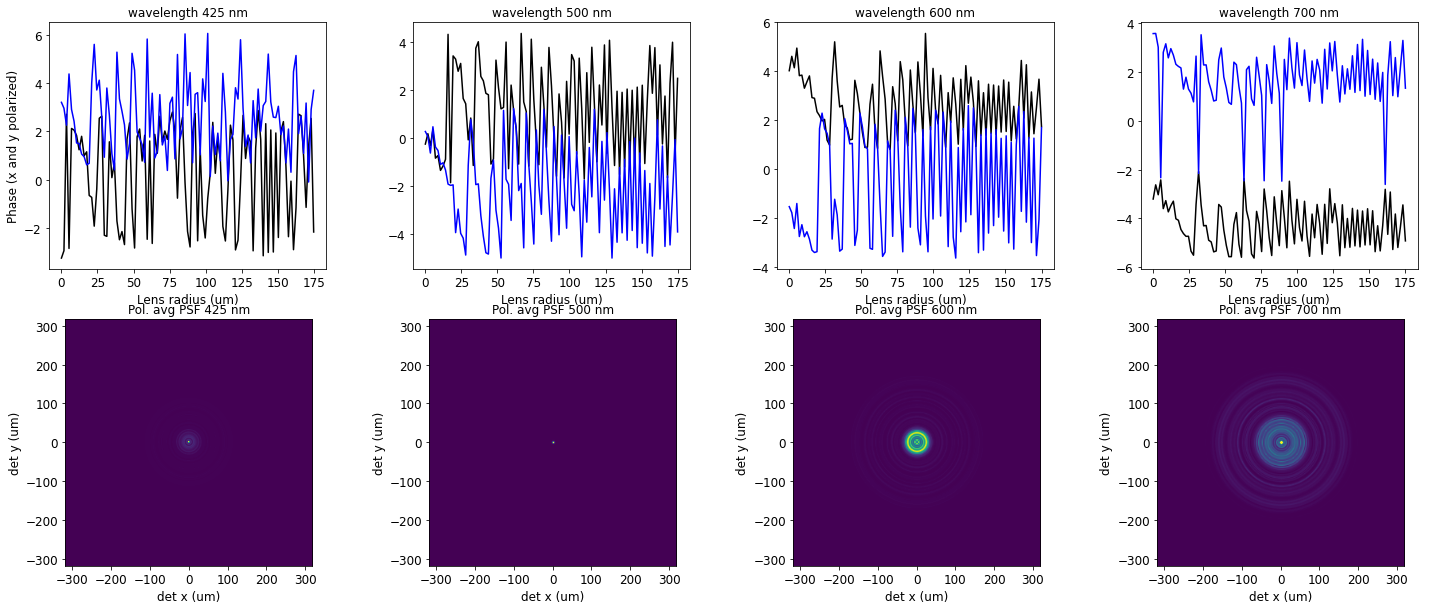

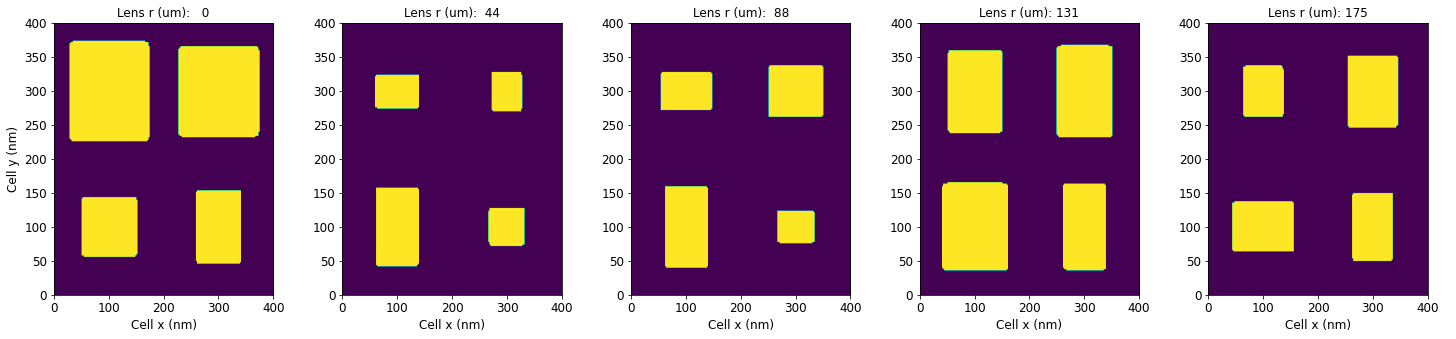

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:76: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  30 4.763580083847046 -0.5743233700181097
Training Log | (Step, time, loss):  31 4.813308954238892 -0.5761006176837405
Training Log | (Step, time, loss):  32 4.739798545837402 -0.5792111868784735
Training Log | (Step, time, loss):  33 4.775026082992554 -0.5813565992245078
Training Log | (Step, time, loss):  34 5.0078511238098145 -0.5832580416157085
Training Log | (Step, time, loss):  35 4.817555904388428 -0.5846720595661202
Training Log | (Step, time, loss):  36 4.786022663116455 -0.585559340470266
Training Log | (Step, time, loss):  37 4.937265157699585 -0.5871612759472431
Training Log | (Step, time, loss):  38 7.694900751113892 -0.5876903125107632
Training Log | (Step, time, loss):  39 5.60637354850769 -0.5878146363297078
Log Training at step: 40


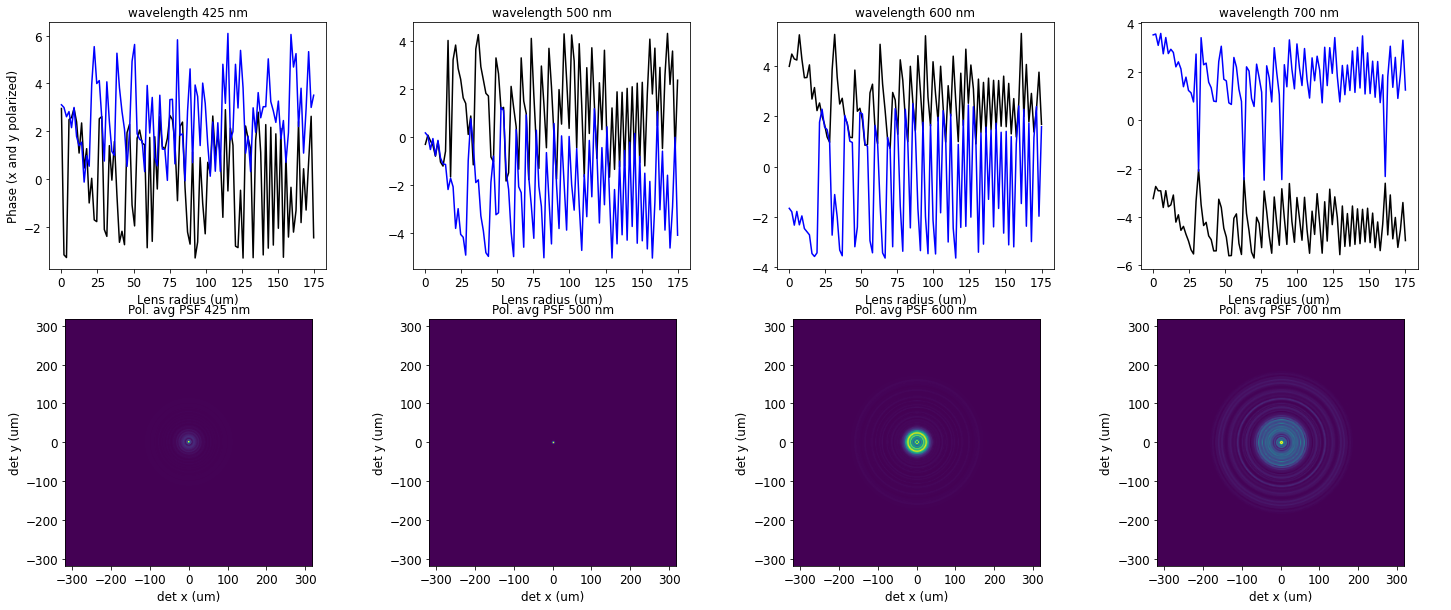

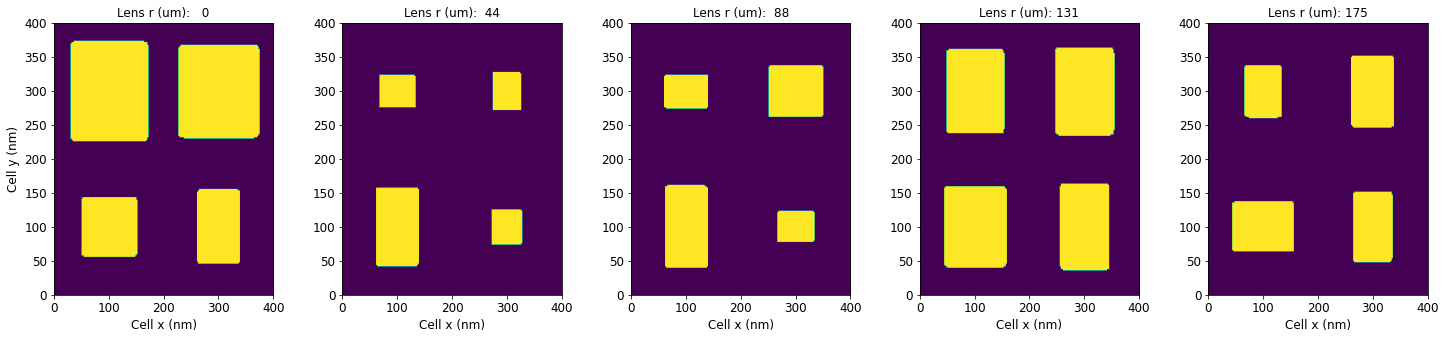

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:76: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


Training Log | (Step, time, loss):  40 4.87747859954834 -0.5893566064210629
Training Log | (Step, time, loss):  41 4.8068342208862305 -0.5888205798527445
Training Log | (Step, time, loss):  42 5.235211610794067 -0.5886830778533014
Training Log | (Step, time, loss):  43 5.401484489440918 -0.5900751637081951
Training Log | (Step, time, loss):  44 4.748908996582031 -0.5899181561950396
Training Log | (Step, time, loss):  45 4.753781080245972 -0.5914210668238471
Training Log | (Step, time, loss):  46 4.767329454421997 -0.5880485088563822
Training Log | (Step, time, loss):  47 4.739780902862549 -0.589874864010287
Training Log | (Step, time, loss):  48 4.787829637527466 -0.5914742924481695
Training Log | (Step, time, loss):  49 4.7504189014434814 -0.5936923438514742
Log Training at step: 50


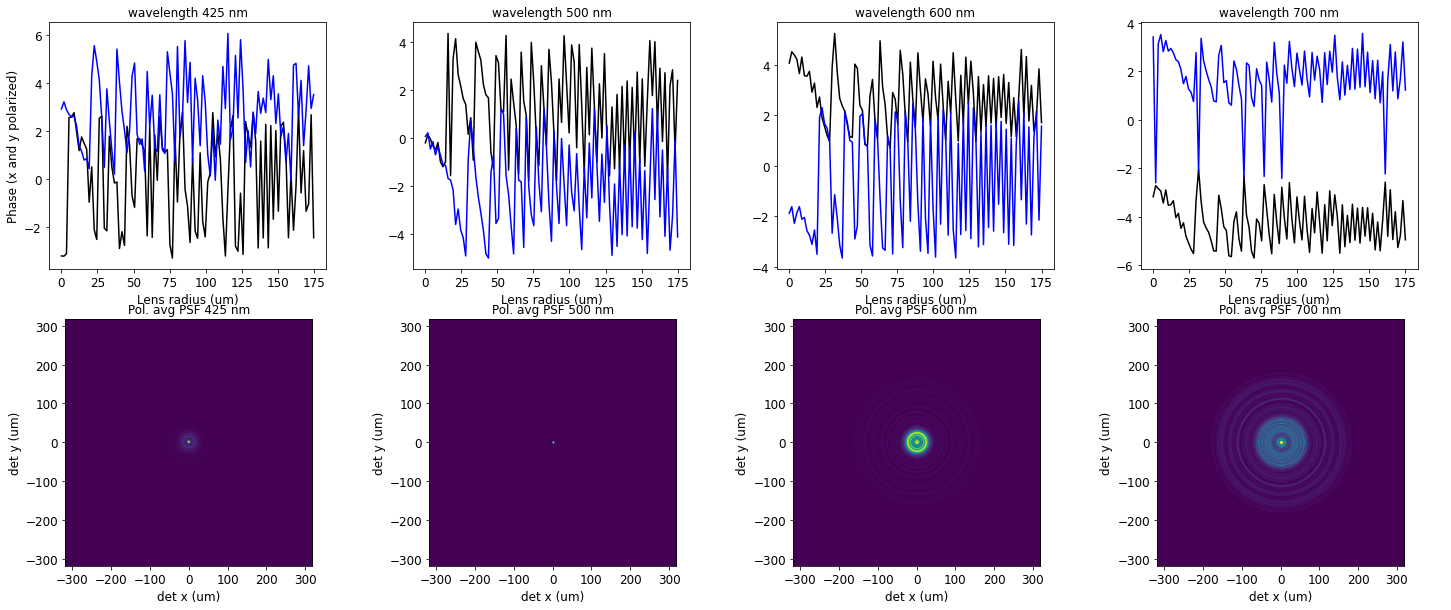

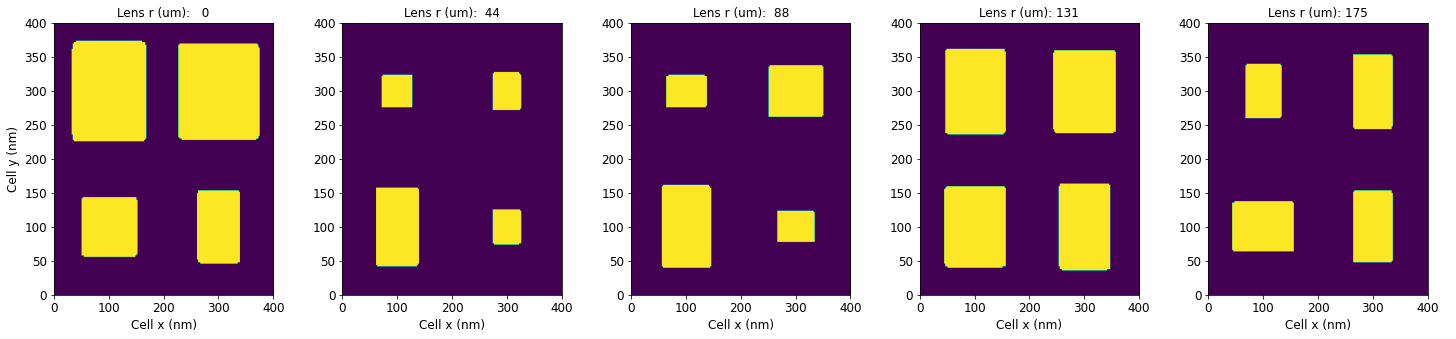

Save Checkpoint Model:

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:76: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")



 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:76: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector), "k-")


In [ ]:
run_broadband_metalens(num_epochs=50, try_gpu=True)